# Waze Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.semi_supervised import LabelPropagation

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", RobustScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def find_best_label_propagation_model(complete_df, missing_values_df, preprocessor):
  
    X_labeled = complete_df.drop("label", axis=1)
    y_labeled = complete_df["label"]
  
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y_labeled)
  
    X_unlabeled = missing_values_df.drop("label", axis=1)
    
    X_combined = pd.concat([X_labeled, X_unlabeled], axis=0)
    y_combined = pd.concat([pd.Series(y_encoded), pd.Series([-1] * len(X_unlabeled))])
    
    label_propagation = LabelPropagation()
    
    pipeline = create_sklearn_pipeline(preprocessor, label_propagation)
    pipeline.fit(X_combined, y_combined)
    
    pseudo_labels = pipeline.named_steps['model'].transduction_[len(X_labeled):]
    X_unlabeled['pseudo_label'] = pseudo_labels
    
    return X_unlabeled

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,15))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/waze_dataset.csv")
df

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone
14995,14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android
14996,14996,retained,273,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone
14997,14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone


In [4]:
df.drop("ID", axis=1, inplace=True)

# Check For Nulls / Dupes

In [5]:
check_for_nulls_dupes(df)

The amount of Null Values: label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

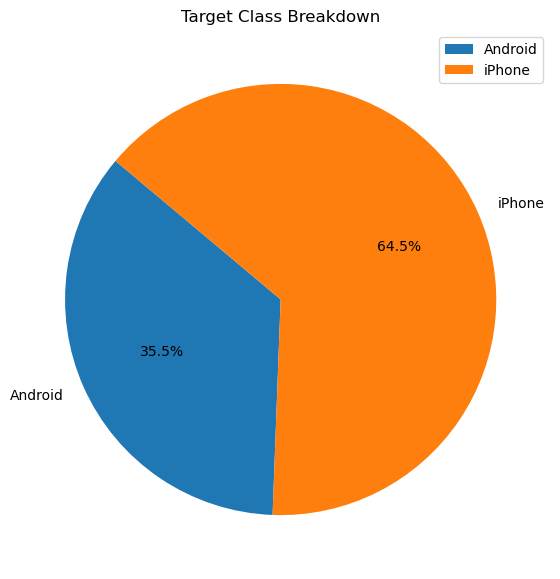

In [6]:
check_class_imbalance(df["device"])

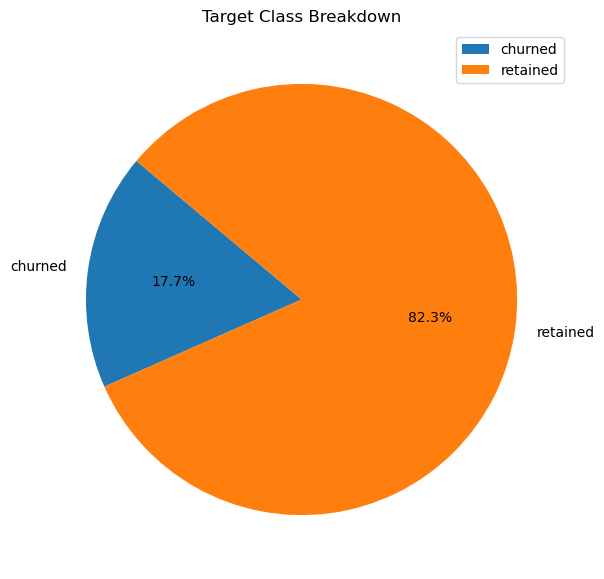

In [7]:
check_class_imbalance(df["label"].dropna())

# Create Preprocessor

In [8]:
numeric_types = df.select_dtypes(exclude="object")
categorical_types = df.select_dtypes(include="object").drop("label", axis=1)

preprocessor = create_column_transformer(categorical_types.columns, numeric_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['device'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days'],
      dtype='object'))])

# Imbalanced Dataset

In [9]:
missing_values = df[df.isna().any(axis=1)]

In [10]:
missing_values

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
77,NaN,63,50,133.104155,783,201,0,2649.015822,1517.209970,19,13,iPhone
80,NaN,116,93,436.060183,1584,283,62,4183.409514,3121.889952,18,15,iPhone
98,NaN,78,64,583.492789,3414,0,0,1811.140893,642.189122,12,11,Android
111,NaN,106,102,113.379056,2228,14,0,2817.481840,2011.724274,17,13,Android
142,NaN,32,26,222.129310,208,55,10,2459.816477,874.427617,11,7,iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...
14941,NaN,191,160,485.328204,1287,25,0,6468.181924,3466.104564,14,14,iPhone
14943,NaN,48,38,96.797017,555,0,6,8266.129497,5902.351711,19,19,iPhone
14945,NaN,34,29,134.416604,1643,268,2,4554.007843,1579.211201,18,17,Android
14972,NaN,220,181,256.212166,1718,360,23,5586.913459,4104.440202,19,18,iPhone


# 700 Rows Are missing a target column. We could do an unsupervised learning model to cluster these values into the right buckets.

In [11]:
missing_values.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [12]:
complete_df = df[df["label"].notna()]
complete_df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


# Semi-Supervised-Learning Algorithm

In [13]:
predicted_values = find_best_label_propagation_model(complete_df, missing_values, preprocessor)

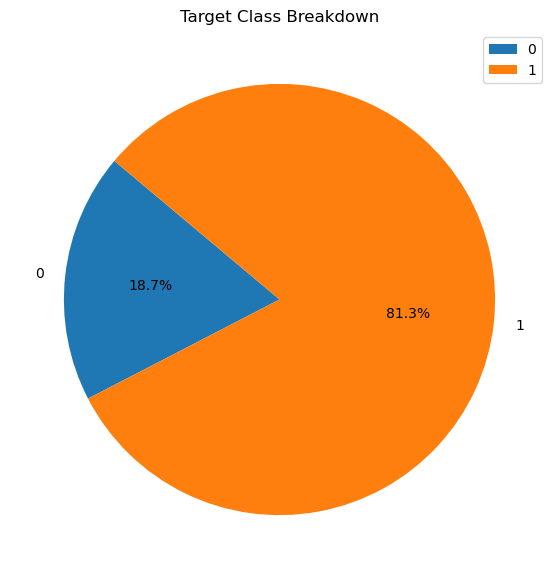

In [14]:
check_class_imbalance(predicted_values["pseudo_label"])

In [15]:
predicted_values["label"] = predicted_values["pseudo_label"].apply(lambda x: "retained" if x == 1 else "churned")
predicted_values.drop("pseudo_label", axis=1, inplace=True)

In [16]:
full_df = pd.concat([complete_df, predicted_values], axis=0)

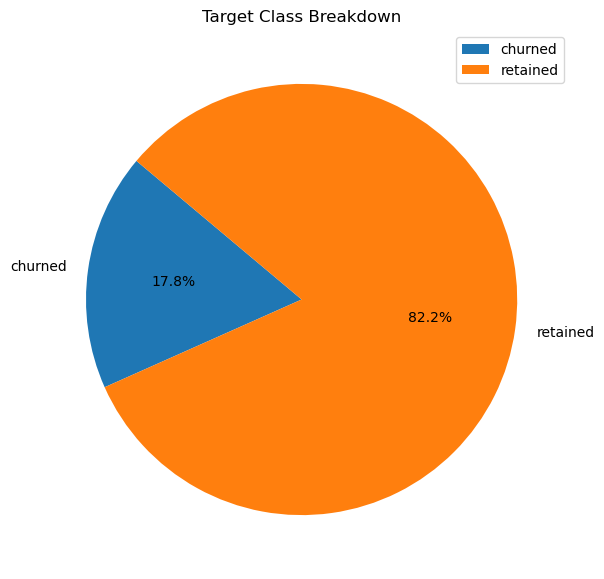

In [17]:
check_class_imbalance(full_df["label"])

#### We Have successfully imputed the missing values

# Visuals

In [18]:
plot_distribution(full_df, "hist")
plot_distribution(numeric_types, "box")

# Histogram Visual

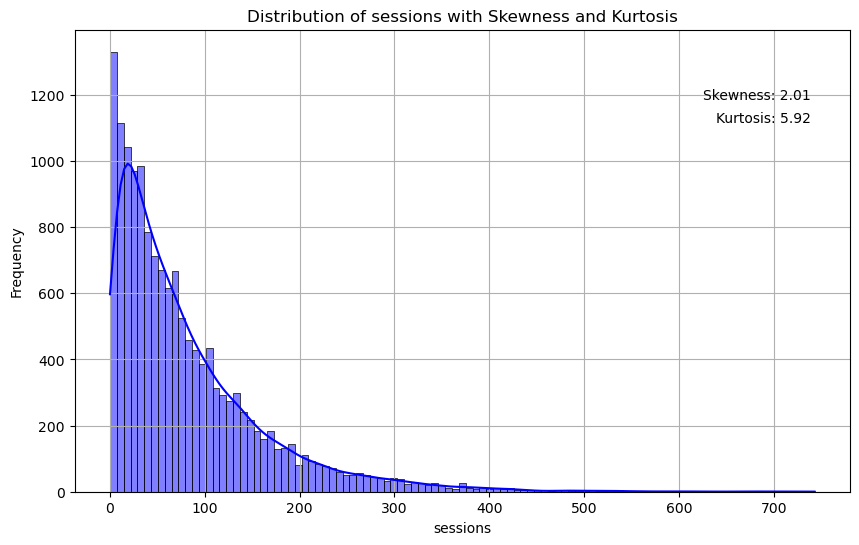

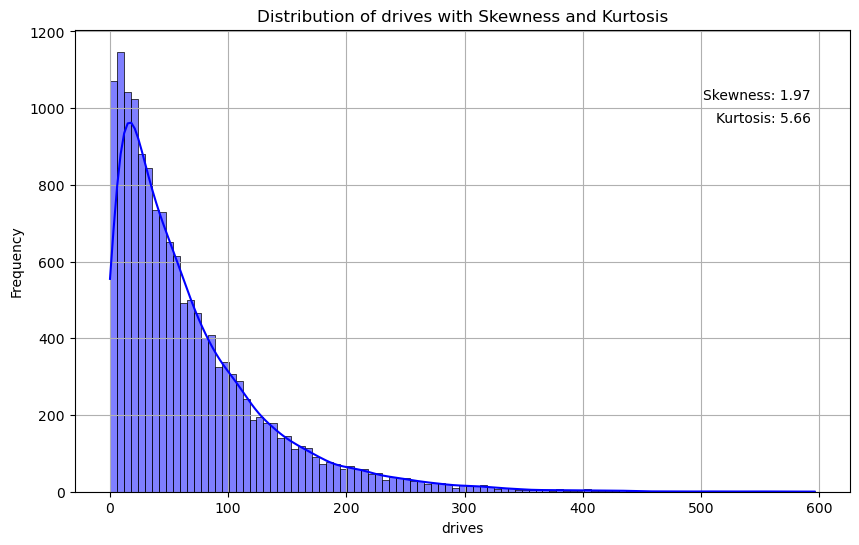

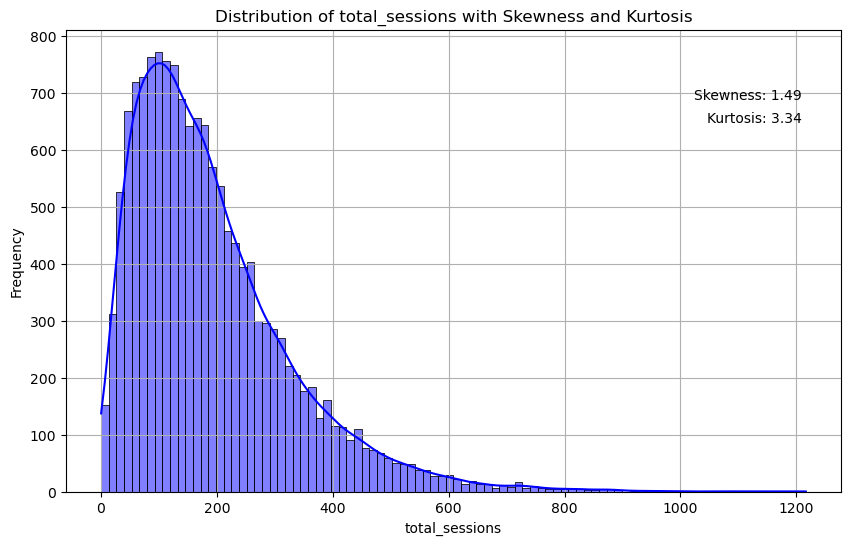

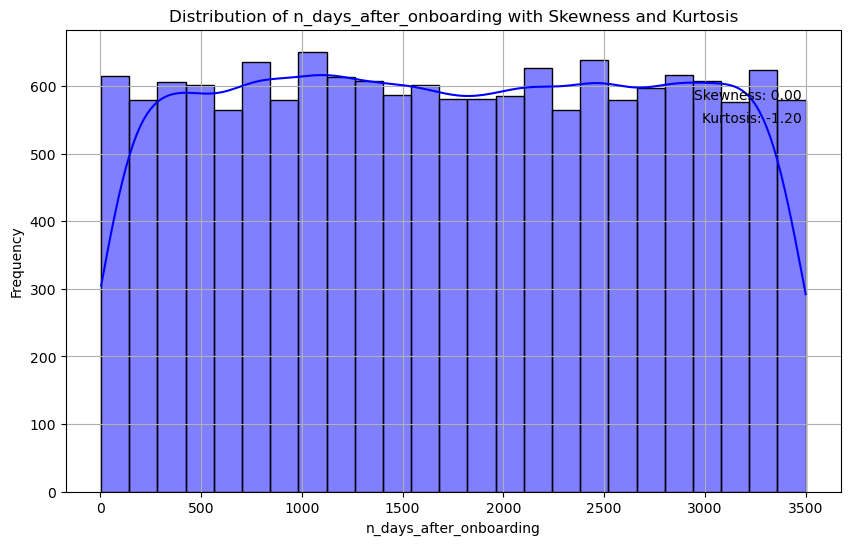

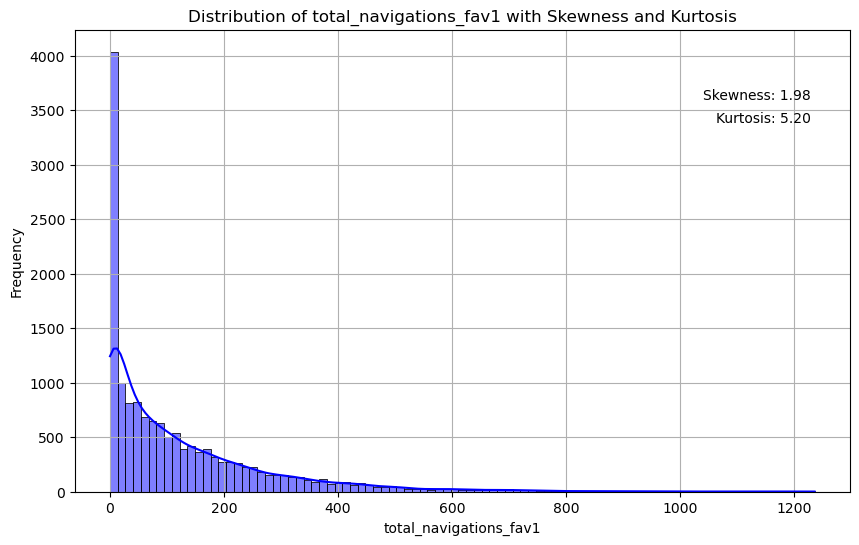

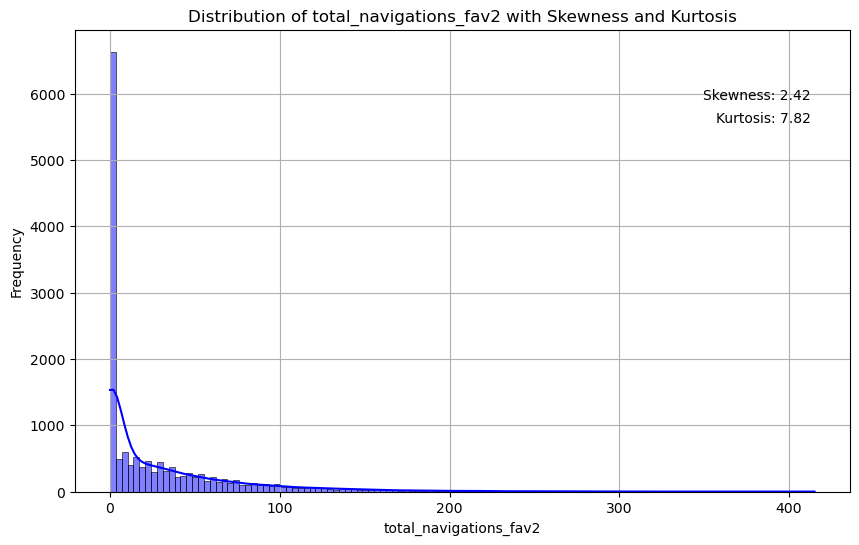

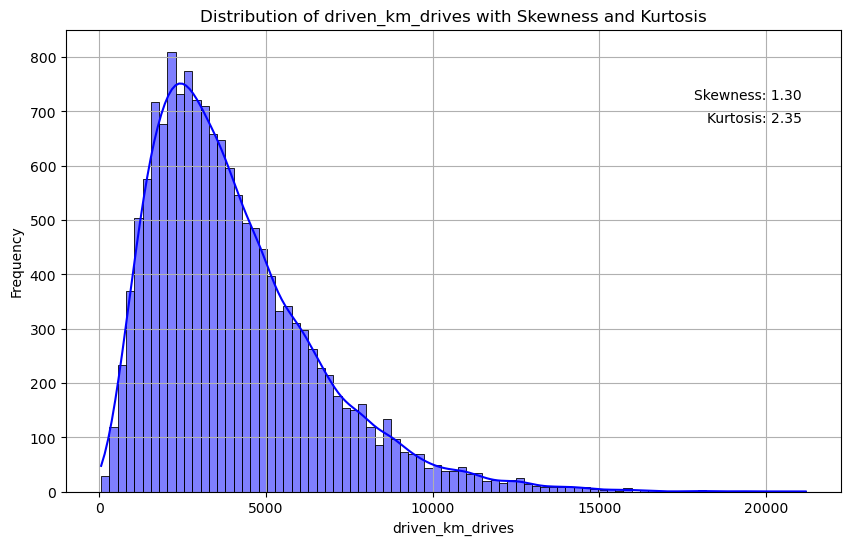

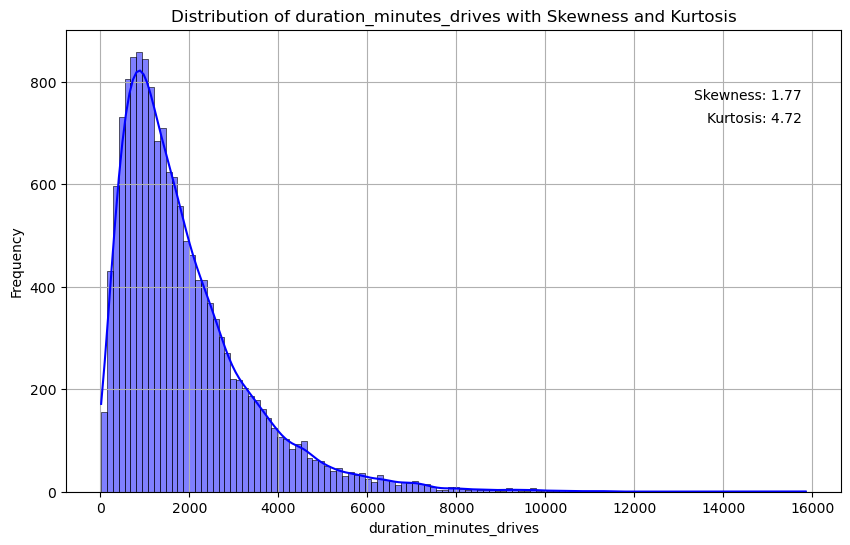

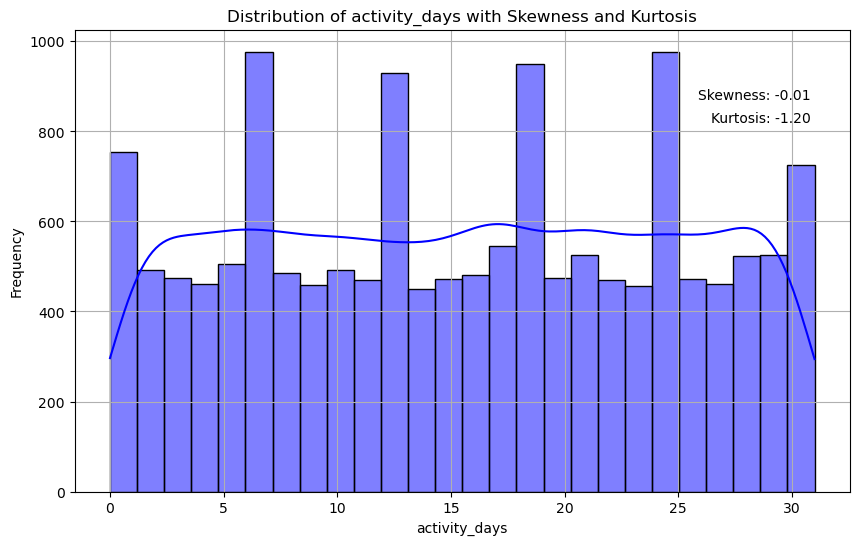

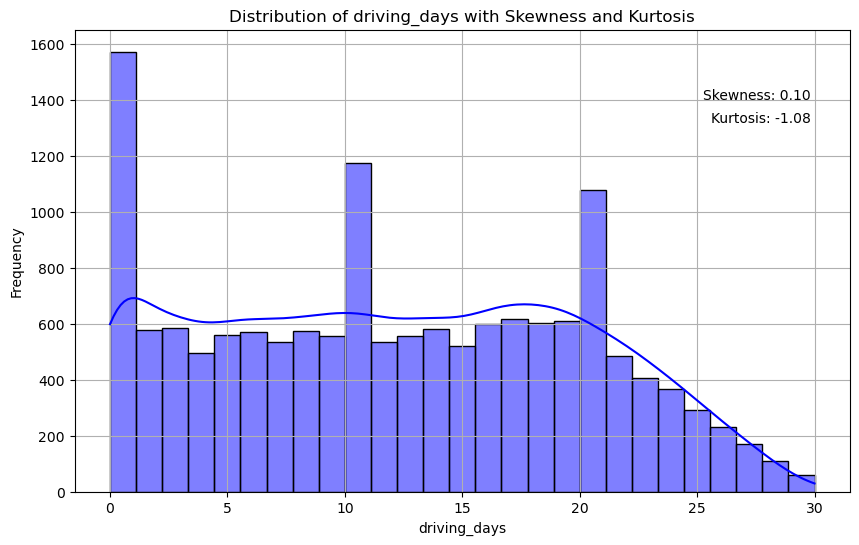

In [110]:
dist_plot(numeric_types)

# Aggregate Visuals

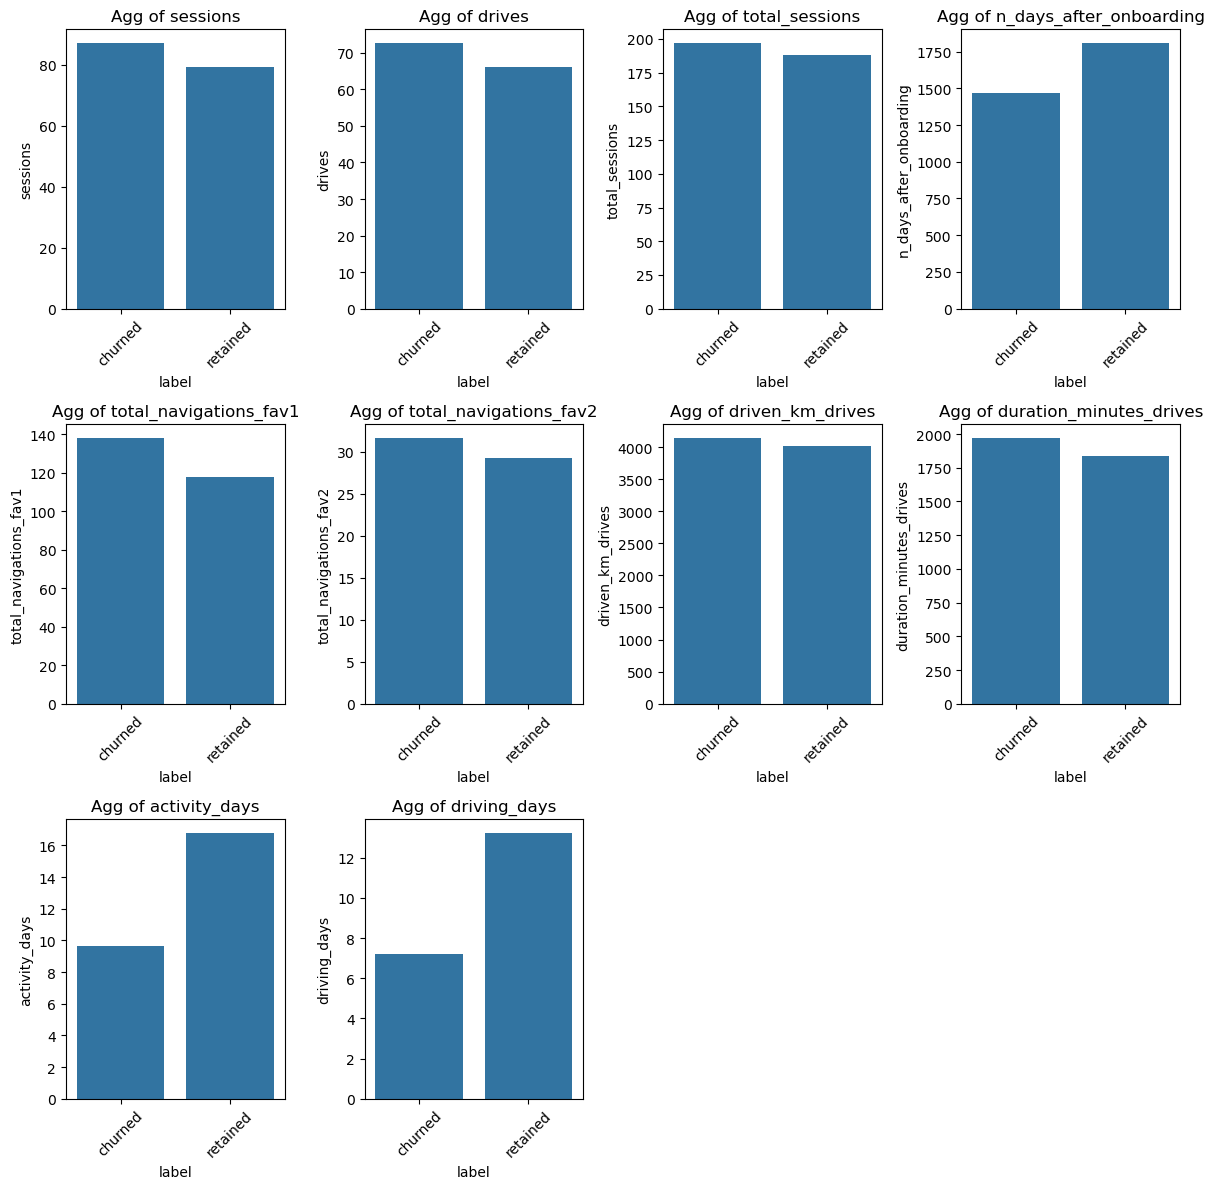

In [112]:
aggregate_dataset(full_df, numeric_types.columns, "label", "mean")

# Heat Map

<AxesSubplot:>

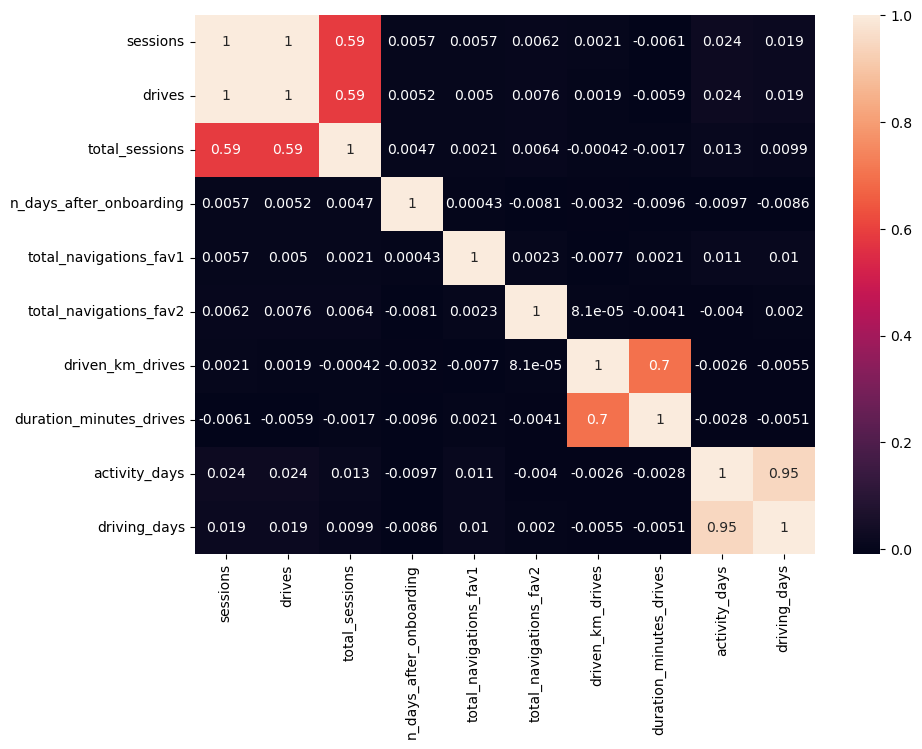

In [114]:
relations = numeric_types.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(data=relations, annot=True)

# Scatter Plot

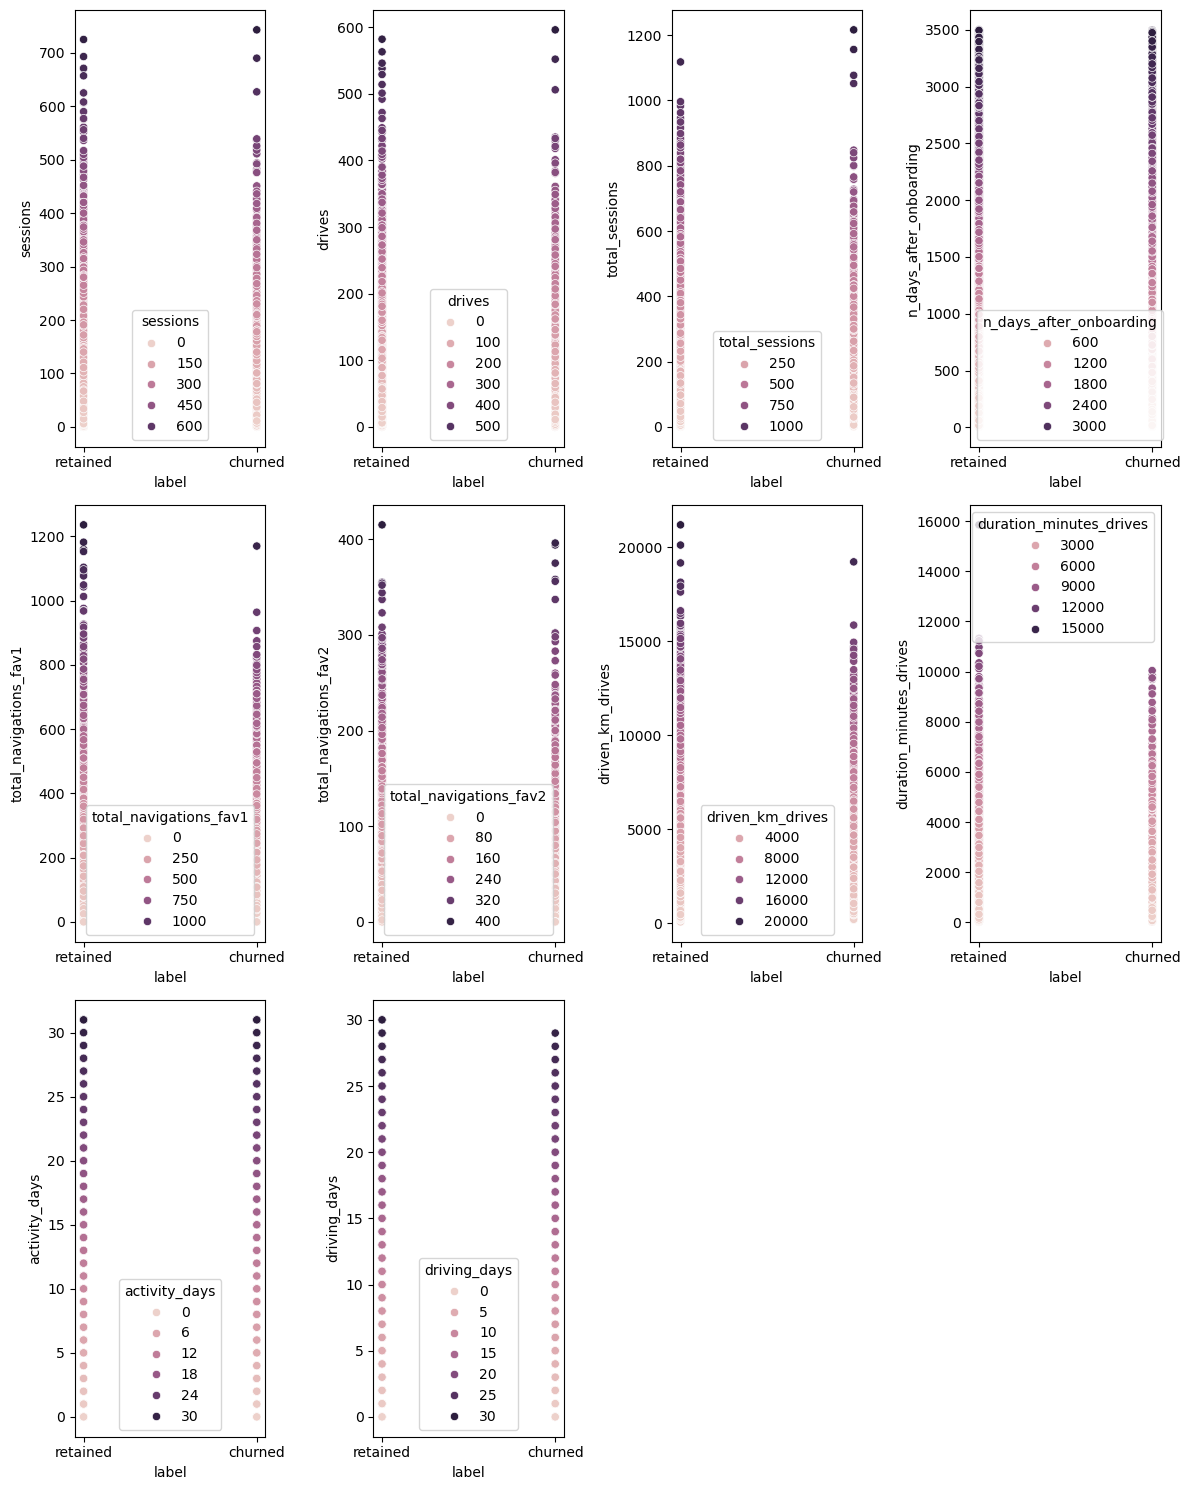

In [125]:
scatter_plot(full_df, numeric_types.columns, "label")

# Separate Features

In [127]:
X = full_df.drop("label", axis=1)
y = full_df["label"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

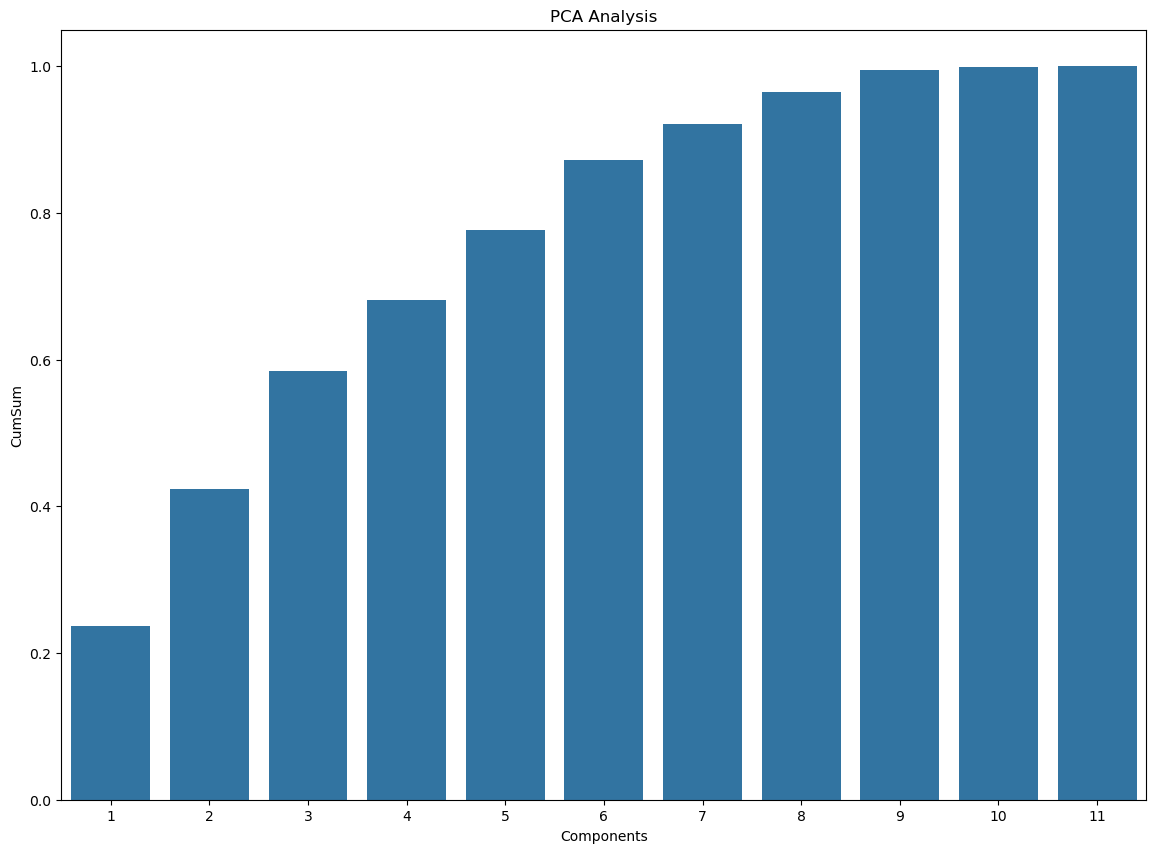

,Component,CumSum
0,1,0.237095
1,2,0.423200
2,3,0.584944
3,4,0.681124
4,5,0.776964
5,6,0.871742
6,7,0.921700
7,8,0.965474
8,9,0.994887
9,10,0.999769


In [128]:
pca_analysis(X, preprocessor)

# Diminishing Returns for 8-11 columns

# Create Metrics

In [129]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

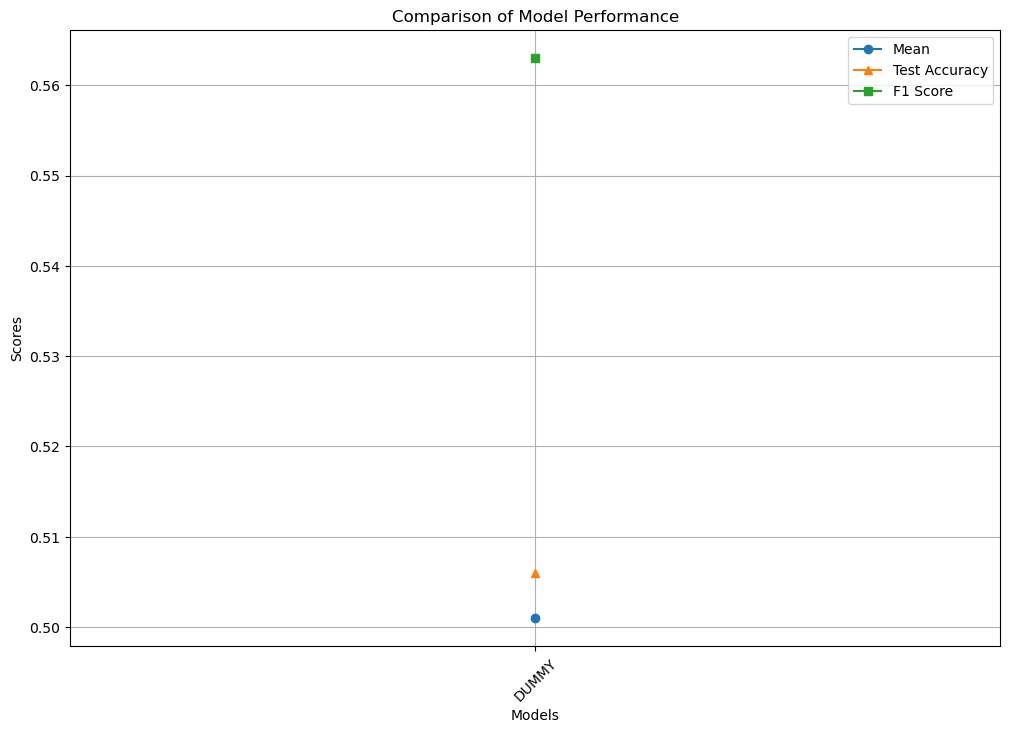

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
0,DUMMY,0.501,0.0,0.012,0.506,0.506,0.712,0.563


In [130]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

# Test K Best Columns

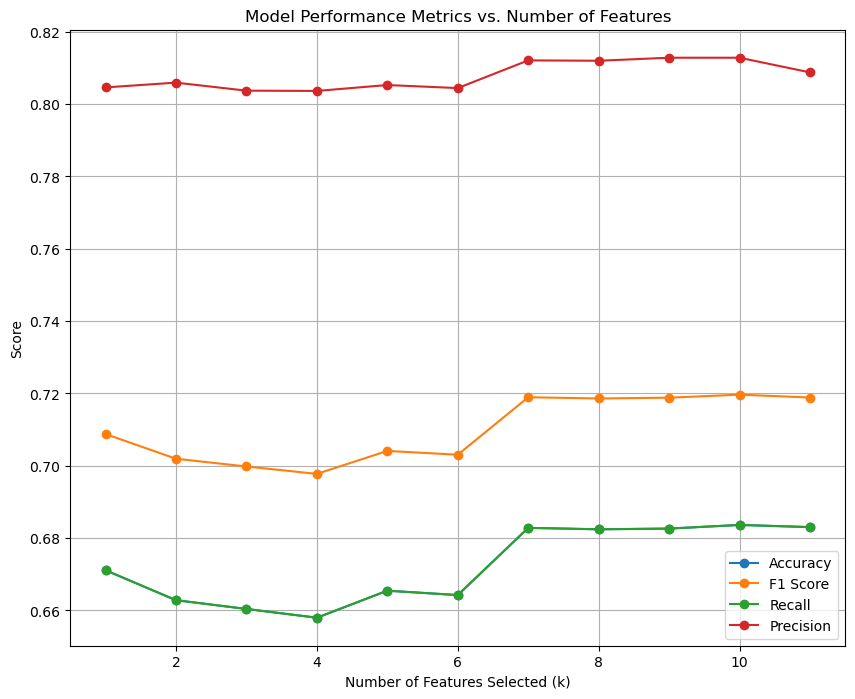

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,LR,1,activity_days,0.671111,0.708768,0.671111,0.804613
1,LR,2,"activity_days, driving_days",0.662828,0.701937,0.662828,0.805932
2,LR,3,"drives, activity_days, driving_days",0.660404,0.699794,0.660404,0.803713
3,LR,4,"sessions, drives, activity_days, driving_days",0.657980,0.697752,0.657980,0.803633
4,LR,5,"sessions, drives, total_navigations_fav1, acti...",0.665455,0.704104,0.665455,0.805266
5,LR,6,"sessions, drives, total_navigations_fav1, tota...",0.664242,0.703046,0.664242,0.804425
6,LR,7,"sessions, drives, n_days_after_onboarding, tot...",0.682828,0.718940,0.682828,0.812085
7,LR,8,"sessions, drives, total_sessions, n_days_after...",0.682424,0.718599,0.682424,0.811981
8,LR,9,"device_Android, device_iPhone, sessions, drive...",0.682626,0.718822,0.682626,0.812819
9,LR,10,"device_Android, device_iPhone, sessions, drive...",0.683636,0.719656,0.683636,0.812816


In [131]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
sample_model = SMOTE()
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

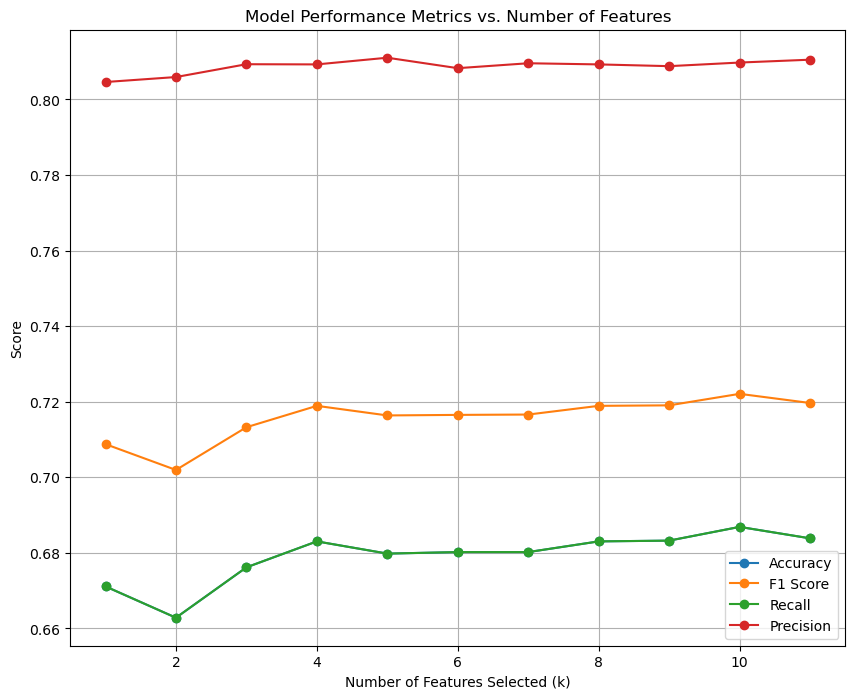

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,LR,1,activity_days,0.671111,0.708768,0.671111,0.804613
1,LR,2,"activity_days, driving_days",0.662828,0.701937,0.662828,0.805932
2,LR,3,"n_days_after_onboarding, activity_days, drivin...",0.676162,0.713248,0.676162,0.809325
3,LR,4,"n_days_after_onboarding, duration_minutes_driv...",0.683030,0.718906,0.683030,0.809276
4,LR,5,"n_days_after_onboarding, total_navigations_fav...",0.679798,0.716368,0.679798,0.811045
5,LR,6,"drives, n_days_after_onboarding, total_navigat...",0.680202,0.716512,0.680202,0.808279
6,LR,7,"sessions, drives, n_days_after_onboarding, tot...",0.680202,0.716603,0.680202,0.809580
7,LR,8,"sessions, drives, n_days_after_onboarding, tot...",0.683030,0.718906,0.683030,0.809276
8,LR,9,"device_iPhone, sessions, drives, n_days_after_...",0.683232,0.719037,0.683232,0.808812
9,LR,10,"device_Android, device_iPhone, sessions, drive...",0.686869,0.722084,0.686869,0.809768


In [132]:
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


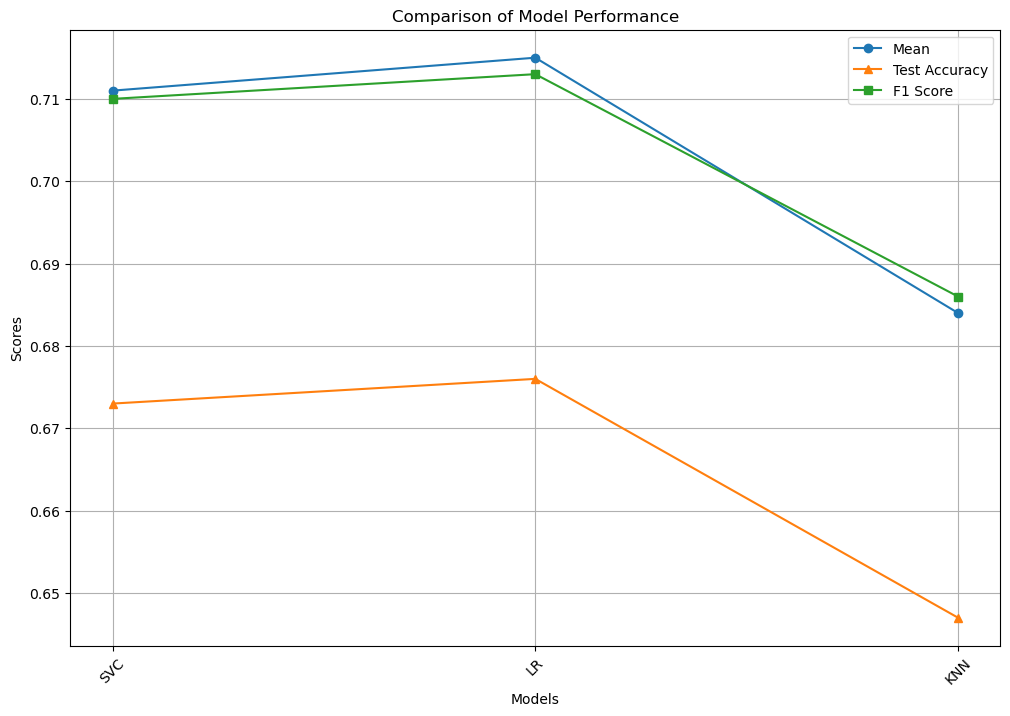

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
1,LR,0.715,0.0,0.009,0.676,0.676,0.807,0.713
0,SVC,0.711,0.0,0.010,0.673,0.673,0.806,0.710
2,KNN,0.684,0.0,0.011,0.647,0.647,0.770,0.686


In [133]:
kbest = SelectKBest(score_func=mutual_info_classif, k=9)
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, f1_metric, sample_model, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


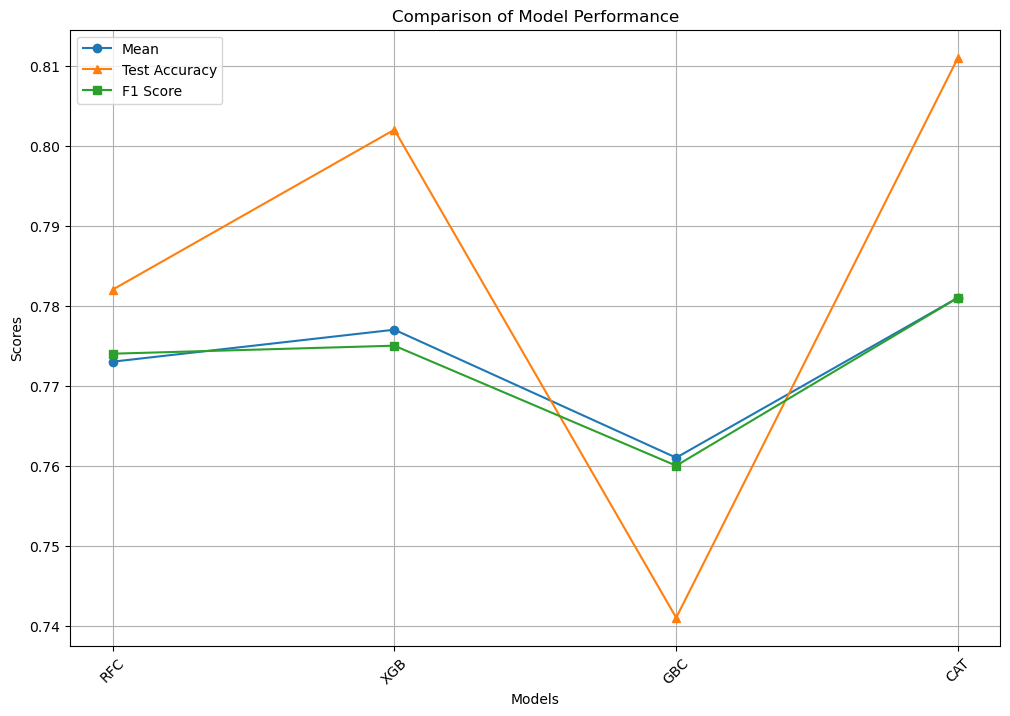

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
3,CAT,0.781,0.0,0.008,0.811,0.811,0.771,0.781
1,XGB,0.777,0.0,0.008,0.802,0.802,0.762,0.775
0,RFC,0.773,0.0,0.009,0.782,0.782,0.767,0.774
2,GBC,0.761,0.0,0.009,0.741,0.741,0.792,0.760


In [134]:
model_names = ["RFC", "XGB", "GBC", "CAT"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, f1_metric, sample_model, kbest)

# Hyper Parameter Tuning

In [136]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200, 300],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 9],
        'model__subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    },
    "CAT":{
    'model__iterations': [100, 500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 10],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__border_count': [32, 64, 128],
    'model__loss_function': ['Logloss', 'CrossEntropy'],
    'model__boosting_type': ['Plain'],
    'model__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}
}

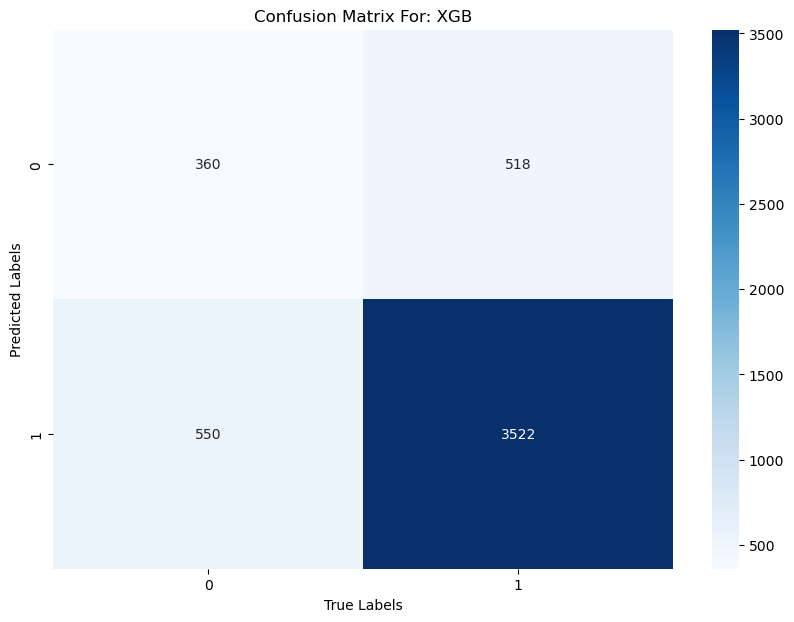

The Best Param: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.02, 'model__colsample_bytree': 0.8}


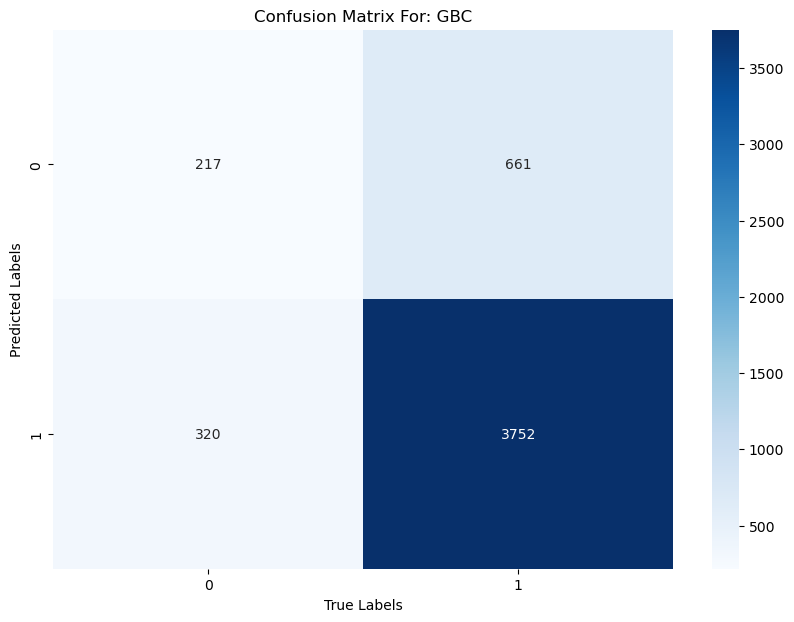

The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 4, 'model__learning_rate': 0.2}


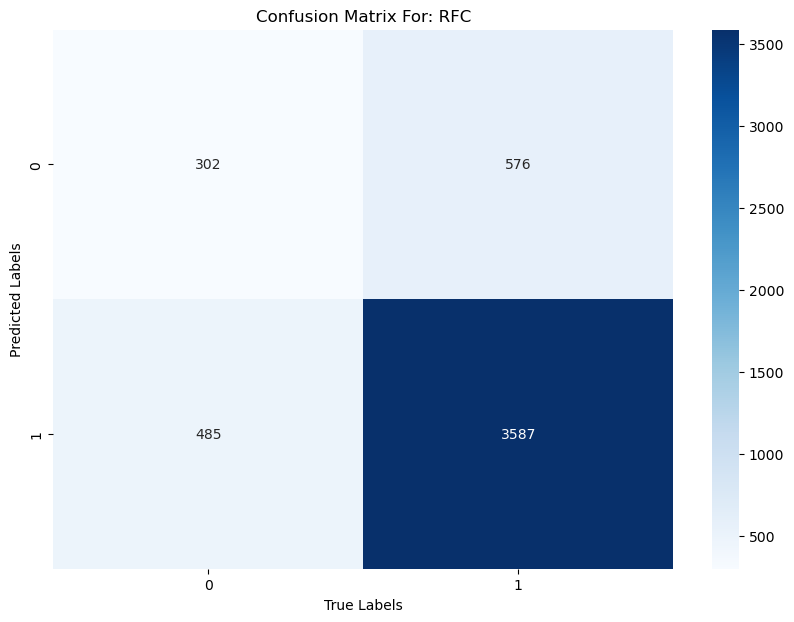

The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': 20}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


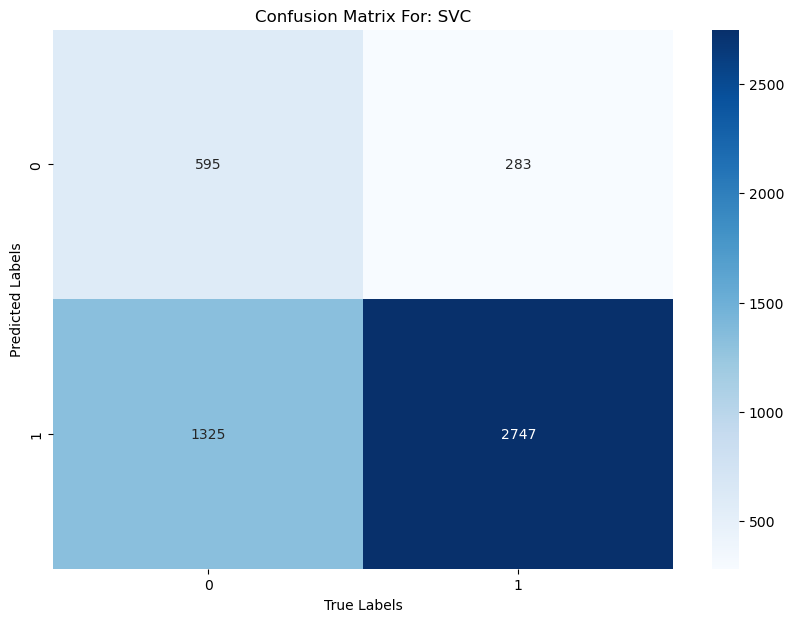

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 4, 'model__C': 10}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


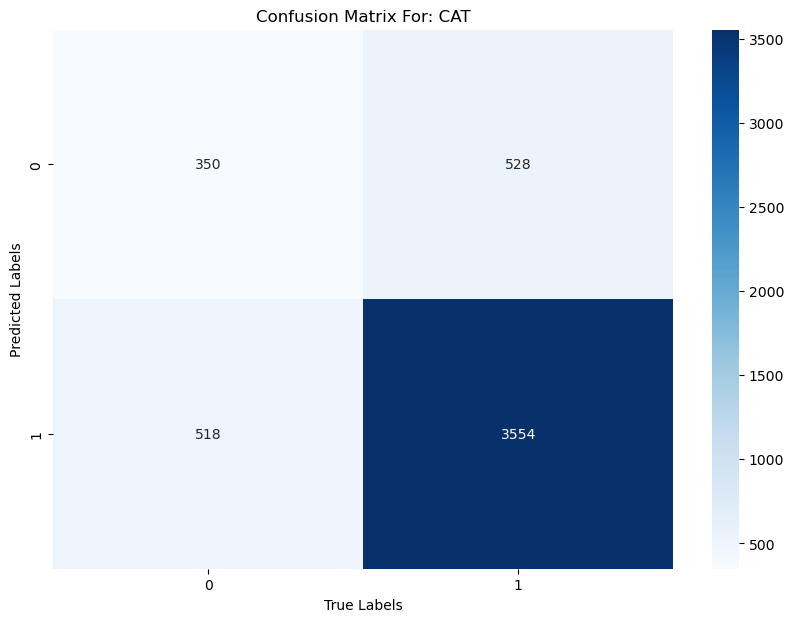

The Best Param: {'model__loss_function': 'CrossEntropy', 'model__learning_rate': 0.01, 'model__l2_leaf_reg': 3, 'model__iterations': 1000, 'model__grow_policy': 'SymmetricTree', 'model__depth': 6, 'model__border_count': 128, 'model__bootstrap_type': 'Bayesian', 'model__boosting_type': 'Plain'}


,Model,Test-Acc,F1-Score,recall-Score,precision-Score
4,CAT,0.788687,0.788211,0.788687,0.787743
0,XGB,0.784242,0.785748,0.784242,0.787321
1,GBC,0.801818,0.781921,0.801818,0.771086
2,RFC,0.785657,0.780983,0.785657,0.776871
3,SVC,0.675152,0.711809,0.675152,0.800761


In [137]:
model_names = ["XGB", "GBC", "RFC", "SVC", "CAT"]
models = grab_selected_models(model_names)
performance_df, best_models = optimization_search(preprocessor, sample_model, model_names, models, X, y_encoded, RandomizedSearchCV, params, f1_metric, kbest)
performance_df.sort_values(by="F1-Score", ascending=False)

In [138]:
stack = [("XGB",best_models[0]), ("GBC", best_models[1]), ("RFC", best_models[2]), ("CAT", best_models[4])]

# Ensemble Learning

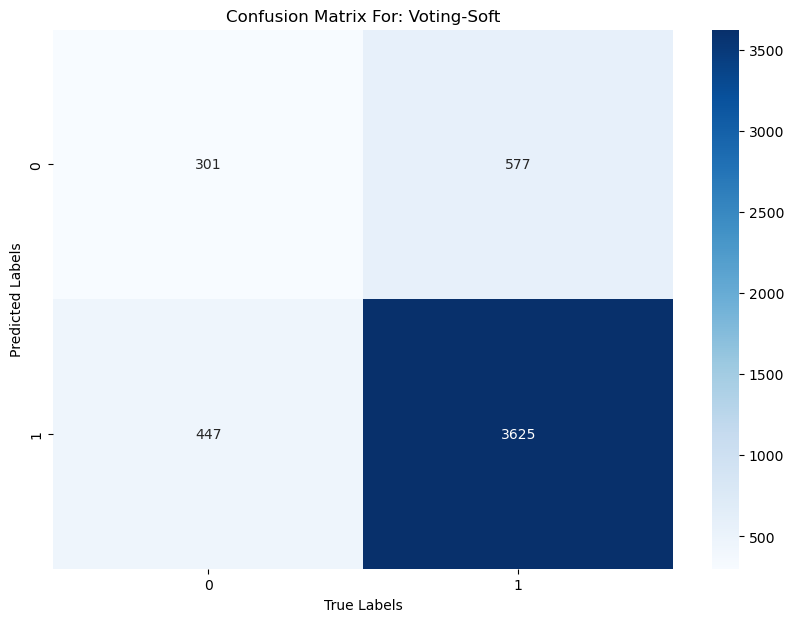

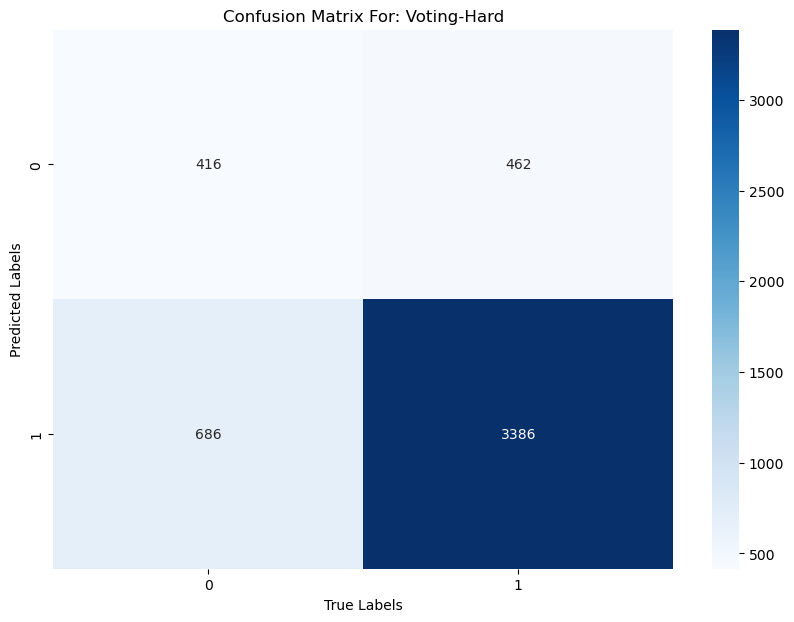

,Model,Test-Acc,F1-Score,recall-Score,precision-Score
0,Voting-Soft,0.793131,0.786487,0.793131,0.781043
1,Voting-Hard,0.768081,0.777920,0.768081,0.790818


In [139]:
voting_hard_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="hard"
)

voting_soft_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="soft"
)

models = [voting_soft_clf, voting_hard_clf]
model_names = ["Voting-Soft", "Voting-Hard"]

test_stacking_models(X, y_encoded, models, model_names)

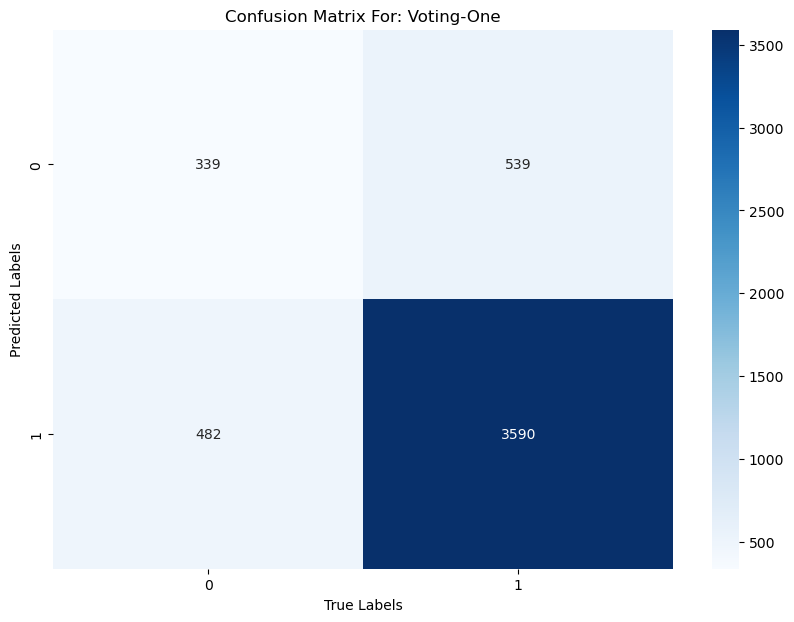

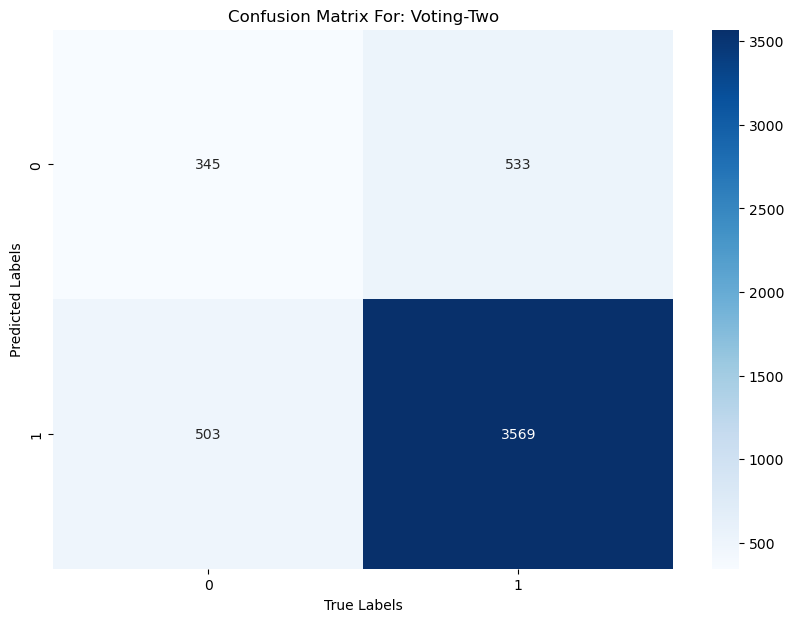

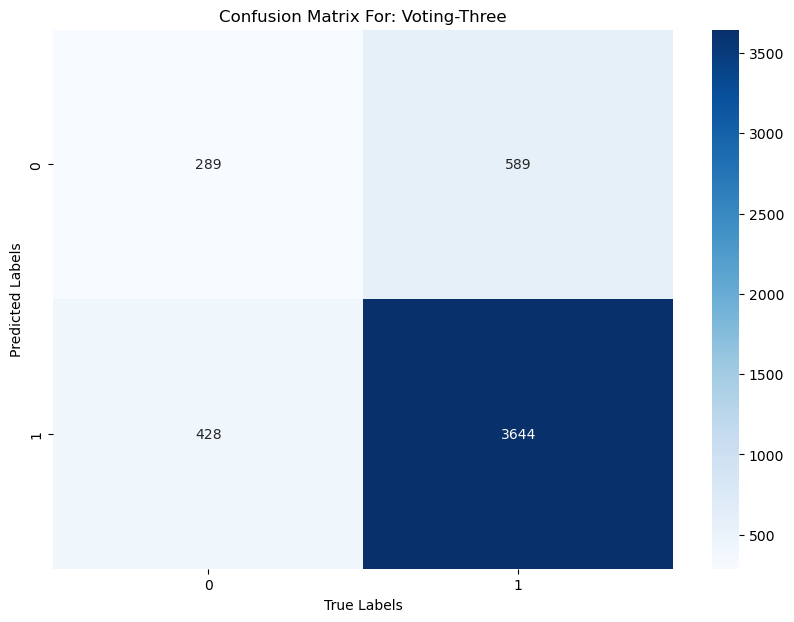

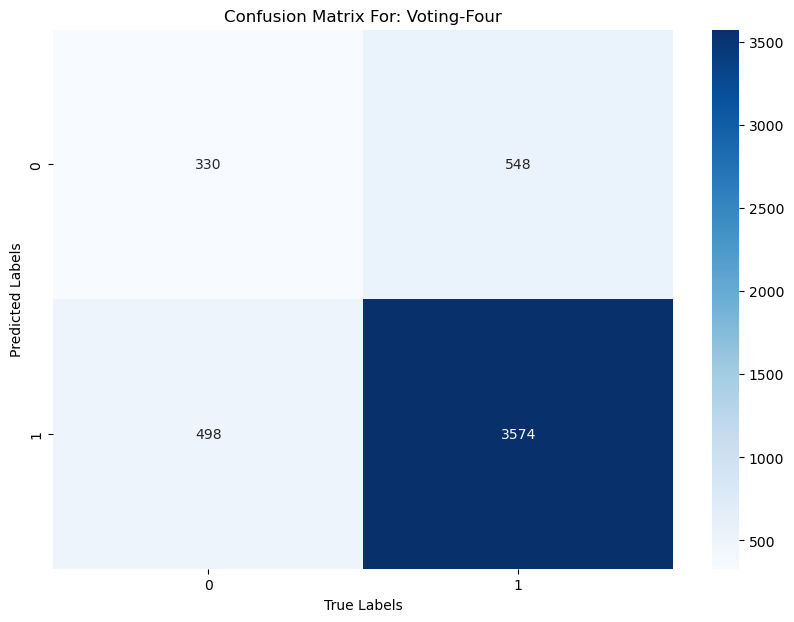

,Model,Test-Acc,F1-Score,recall-Score,precision-Score
2,Voting-Three,0.794545,0.786168,0.794545,0.779656
0,Voting-One,0.793737,0.790994,0.793737,0.788480
1,Voting-Two,0.790707,0.789272,0.790707,0.787900
3,Voting-Four,0.788687,0.786235,0.788687,0.783955


In [140]:
voting_one_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3]
  ],
  voting="hard"
)

voting_two_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1]
  ],
  voting="hard"
)

voting_three_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1]
  ],
  voting="soft"
)

voting_four_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  ],
  voting="soft"
)

models = [voting_one_clf, voting_two_clf, voting_three_clf, voting_four_clf]
model_names = ["Voting-One", "Voting-Two", "Voting-Three", "Voting-Four"]

test_stacking_models(X, y_encoded, models, model_names)

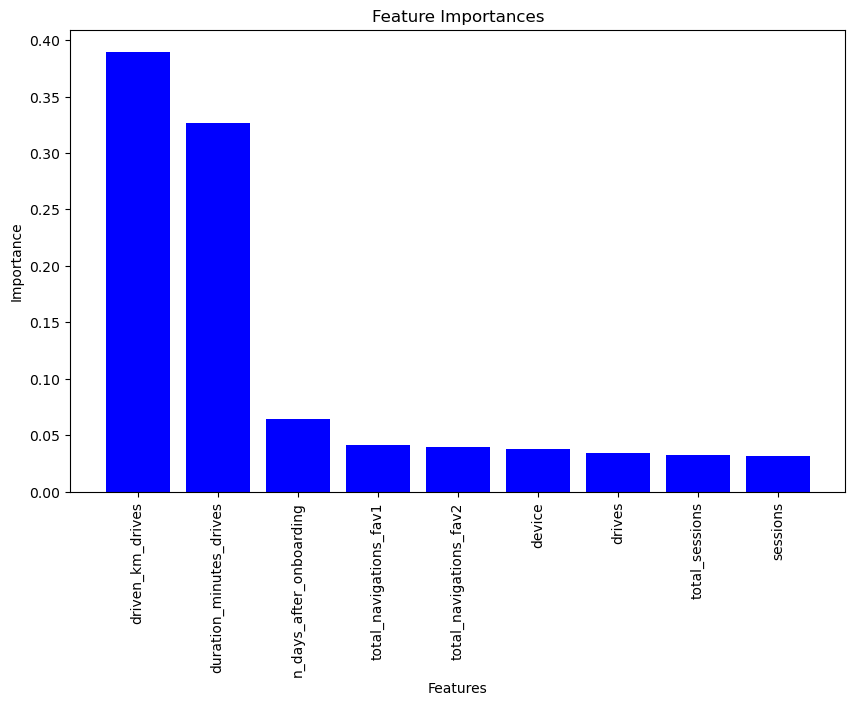

In [141]:
xgb_clf = stack[0][1]
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

xgb_clf.fit(X_train, y_train)
transformed_features = get_feature_names(xgb_clf.named_steps['preprocessor'])
selected_mask = xgb_clf.named_steps['Feature Selection'].get_support()

feature_importances = xgb_clf.named_steps['model'].feature_importances_
all_features = [feature for is_selected, feature in zip(xgb_clf.named_steps['Feature Selection'].get_support(), transformed_features)]


selected_features = [feature for feature, selected in zip(all_features, selected_mask) if selected]
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), [all_features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# Lets try on completed DF

In [142]:
X = complete_df.drop("label", axis=1)
y = complete_df["label"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

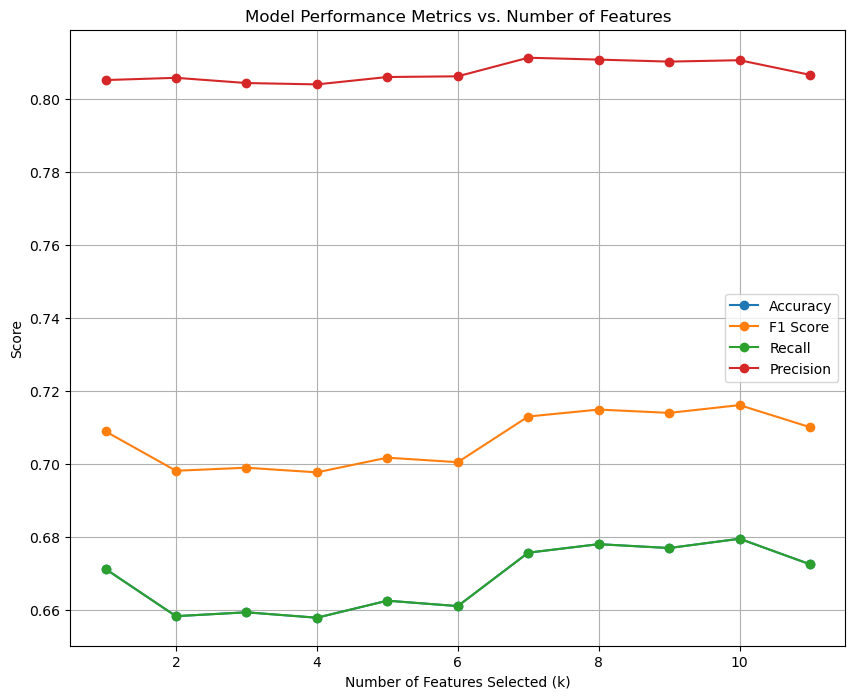

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,LR,1,activity_days,0.671329,0.708982,0.671329,0.805133
1,LR,2,"activity_days, driving_days",0.658402,0.698201,0.658402,0.805748
2,LR,3,"drives, activity_days, driving_days",0.659462,0.699032,0.659462,0.804320
3,LR,4,"sessions, drives, activity_days, driving_days",0.657978,0.697766,0.657978,0.803945
4,LR,5,"sessions, drives, total_navigations_fav1, acti...",0.662640,0.701783,0.662640,0.805968
5,LR,6,"sessions, drives, total_navigations_fav1, tota...",0.661157,0.700543,0.661157,0.806157
6,LR,7,"sessions, drives, n_days_after_onboarding, tot...",0.675779,0.713048,0.675779,0.811247
7,LR,8,"device_Android, sessions, drives, n_days_after...",0.678110,0.714952,0.678110,0.810733
8,LR,9,"device_Android, device_iPhone, sessions, drive...",0.677050,0.714040,0.677050,0.810186
9,LR,10,"device_Android, device_iPhone, sessions, drive...",0.679593,0.716168,0.679593,0.810562


In [144]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
sample_model = SMOTE()
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

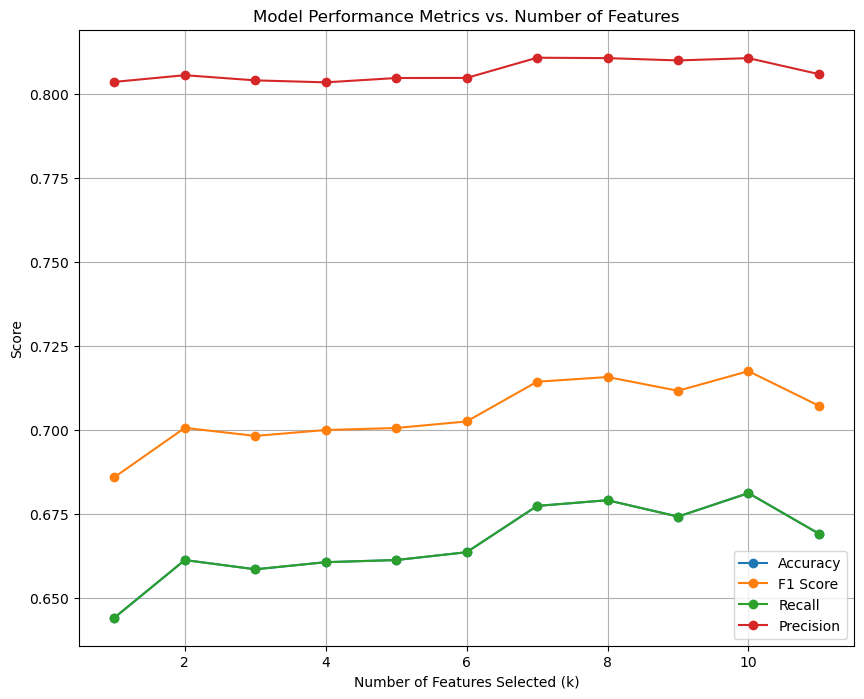

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,LR,1,activity_days,0.644204,0.686024,0.644204,0.803656
1,LR,2,"activity_days, driving_days",0.661369,0.700699,0.661369,0.805647
2,LR,3,"drives, activity_days, driving_days",0.658614,0.698309,0.658614,0.804106
3,LR,4,"sessions, drives, activity_days, driving_days",0.660733,0.700063,0.660733,0.803521
4,LR,5,"sessions, drives, total_navigations_fav1, acti...",0.661369,0.700659,0.661369,0.804803
5,LR,6,"sessions, drives, total_navigations_fav1, tota...",0.663700,0.702615,0.663700,0.804836
6,LR,7,"sessions, drives, n_days_after_onboarding, tot...",0.677474,0.714432,0.677474,0.810846
7,LR,8,"device_Android, sessions, drives, n_days_after...",0.679169,0.715829,0.679169,0.810728
8,LR,9,"device_iPhone, sessions, drives, total_session...",0.674295,0.711743,0.674295,0.810037
9,LR,10,"device_Android, device_iPhone, sessions, drive...",0.681288,0.717578,0.681288,0.810724


In [145]:
metric = mutual_info_classif
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

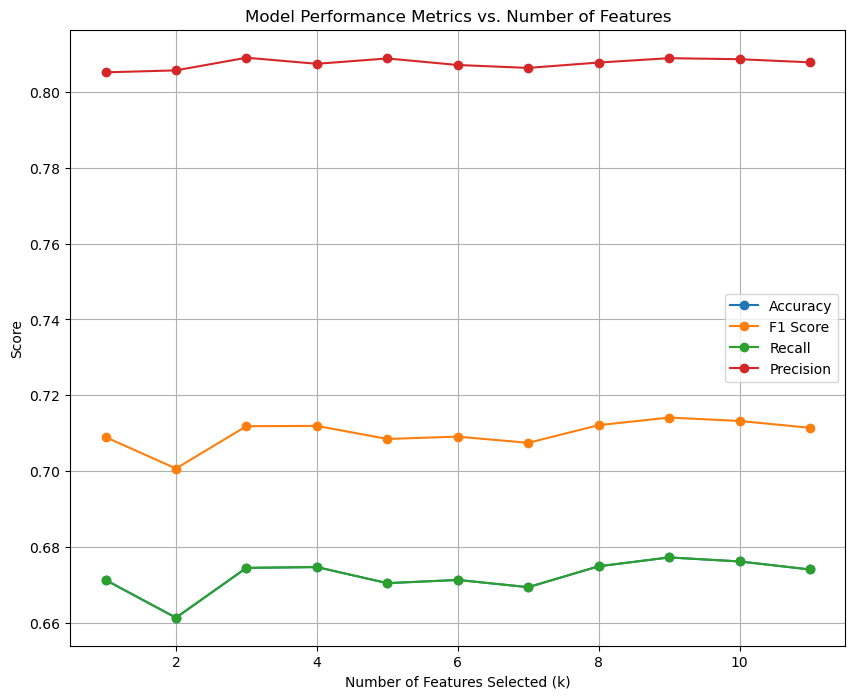

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,LR,1,activity_days,0.671329,0.708982,0.671329,0.805133
1,LR,2,"activity_days, driving_days",0.661369,0.700699,0.661369,0.805647
2,LR,3,"n_days_after_onboarding, activity_days, drivin...",0.674507,0.711856,0.674507,0.808983
3,LR,4,"n_days_after_onboarding, duration_minutes_driv...",0.674719,0.711932,0.674719,0.807383
4,LR,5,"n_days_after_onboarding, total_navigations_fav...",0.670481,0.708494,0.670481,0.808791
5,LR,6,"drives, n_days_after_onboarding, total_navigat...",0.671329,0.709101,0.671329,0.807063
6,LR,7,"sessions, drives, n_days_after_onboarding, tot...",0.669421,0.707470,0.669421,0.806297
7,LR,8,"sessions, drives, n_days_after_onboarding, tot...",0.674931,0.712128,0.674931,0.807713
8,LR,9,"device_iPhone, sessions, drives, n_days_after_...",0.677262,0.714131,0.677262,0.808863
9,LR,10,"device_iPhone, sessions, drives, total_session...",0.676203,0.713237,0.676203,0.808590


In [146]:
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

In [147]:
kbest = SelectKBest(score_func=mutual_info_classif, k=10)

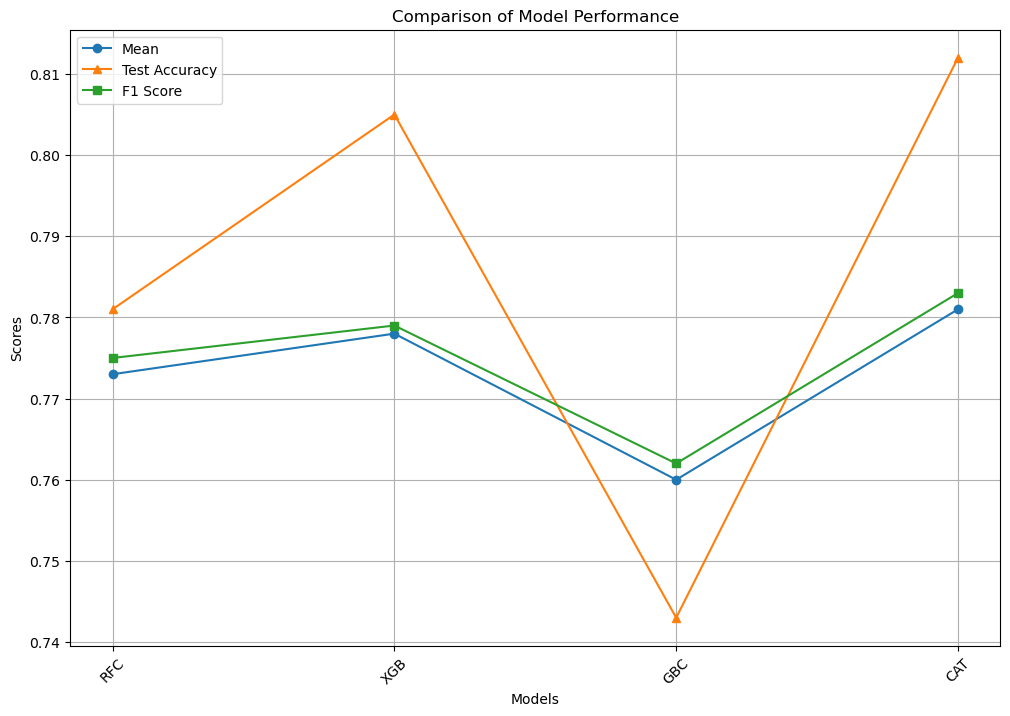

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
3,CAT,0.781,0.0,0.007,0.812,0.812,0.773,0.783
1,XGB,0.778,0.0,0.008,0.805,0.805,0.768,0.779
0,RFC,0.773,0.0,0.009,0.781,0.781,0.770,0.775
2,GBC,0.760,0.0,0.009,0.743,0.743,0.790,0.762


In [148]:
model_names = ["RFC", "XGB", "GBC", "CAT"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, f1_metric, sample_model, kbest)

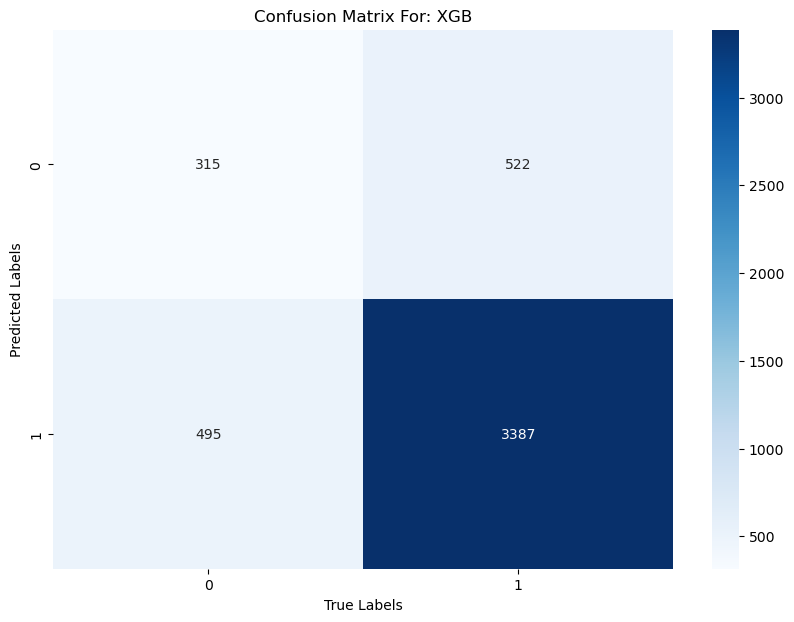

The Best Param: {'model__subsample': 0.6, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}


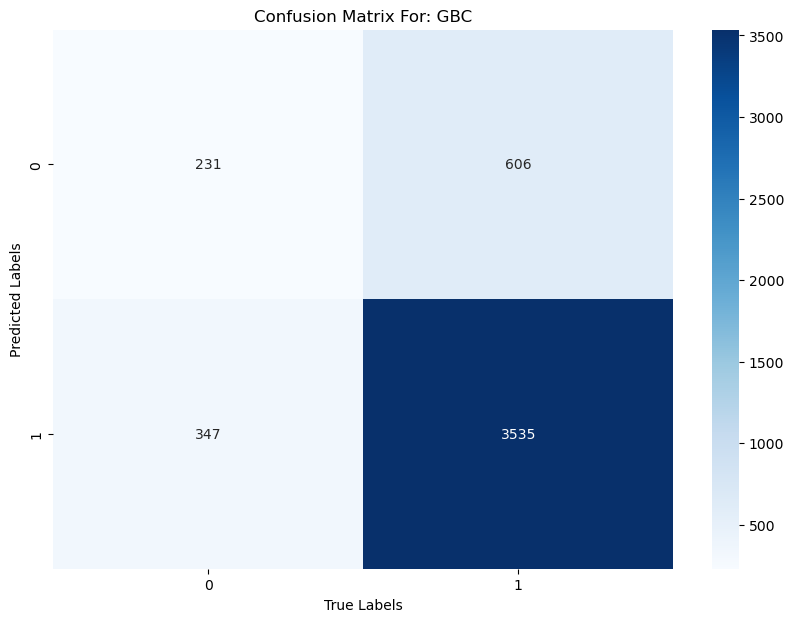

The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 4, 'model__learning_rate': 0.2}


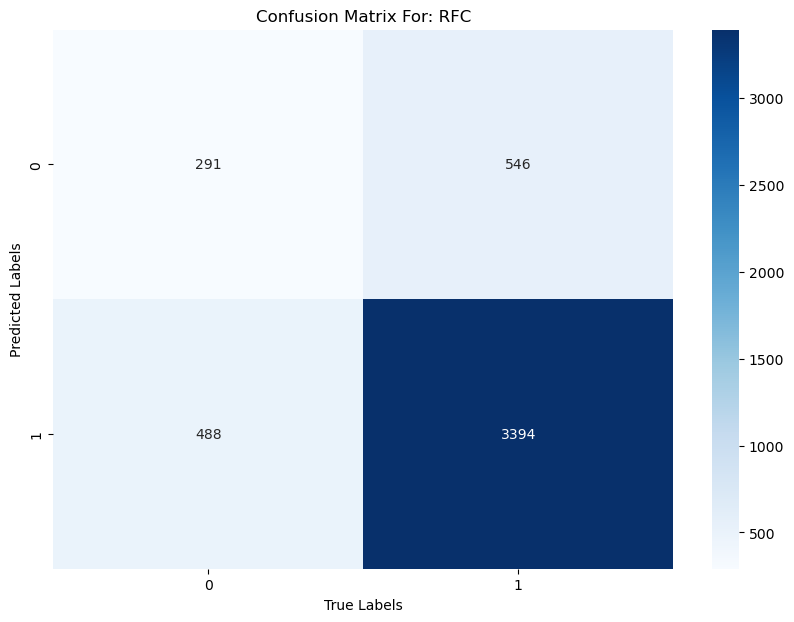

The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}


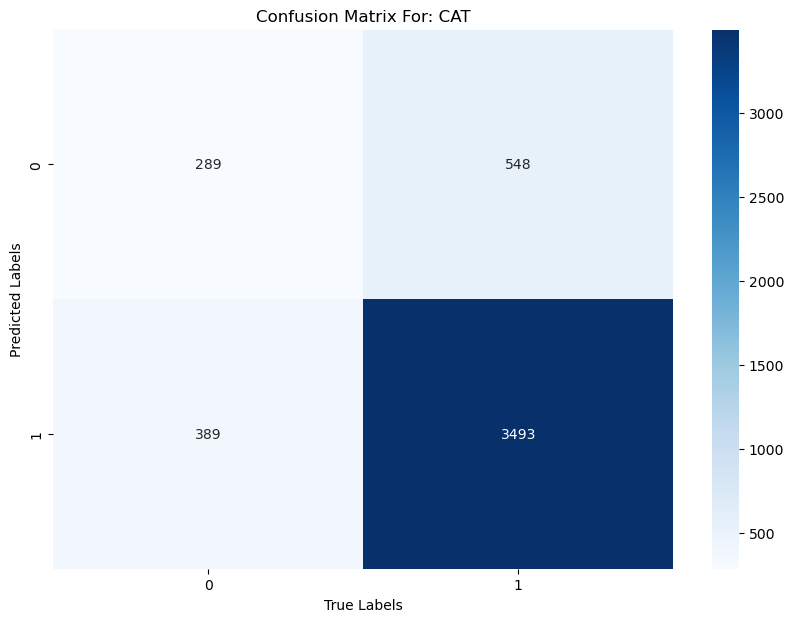

The Best Param: {'model__loss_function': 'Logloss', 'model__learning_rate': 0.01, 'model__l2_leaf_reg': 1, 'model__iterations': 500, 'model__grow_policy': 'Lossguide', 'model__depth': 10, 'model__border_count': 128, 'model__bootstrap_type': 'MVS', 'model__boosting_type': 'Plain'}


,Model,Test-Acc,F1-Score,recall-Score,precision-Score
3,CAT,0.801441,0.793014,0.801441,0.786679
0,XGB,0.784488,0.783095,0.784488,0.781756
1,GBC,0.798050,0.782828,0.798050,0.773133
2,RFC,0.780886,0.777766,0.780886,0.774890


In [149]:
model_names = ["XGB", "GBC", "RFC", "CAT"]
models = grab_selected_models(model_names)
performance_df, best_models = optimization_search(preprocessor, sample_model, model_names, models, X, y_encoded, RandomizedSearchCV, params, f1_metric, kbest)
performance_df.sort_values(by="F1-Score", ascending=False)